In [58]:
import json
import numpy as np
from numpy import linalg as LA
from scipy import stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, accuracy_score
import math

In [59]:
def rrm_event(bin_size,data):
    #print("Inside rrm_event()")
    baseline_start=0
    response_end=.2
    event_window=np.arange(baseline_start,response_end, bin_size)
    total_bins=len(event_window)
    event_times=data['events']
    neurons=data['neurons']
    relative_spikes=[]
    all_events=[]

    rrm=[]


    for event in event_times:
        #print('new loop')
        event_vals=event_times[event]
        all_neurons=[]
        for neuron in neurons:
            neuron_val=neurons[neuron]
            relative_spikes=[]
            rrm=[]
            for val in event_vals:
                relative_spikes.append(list(np.array(neuron_val)-val))


            for relative_spike in relative_spikes:
                binned_spikes = np.histogram(relative_spike, total_bins, range = (baseline_start, response_end))[0]
                rrm.append(list(binned_spikes))

            all_neurons.append(rrm)

        all_events.append(all_neurons)


    return(all_events)


def kmean(all_events):
    rrm_1=all_events[0]
    rrm_2=all_events[1]
    rrm_3=all_events[2]
    rrm_4=all_events[3]

    #print ('rrm shape: ', np.shape(rrm_2))

    rrm1_t = np.mean(rrm_1, axis=0)  
    rrm2_t = np.mean(rrm_2, axis=0)  
    rrm3_t = np.mean(rrm_3, axis=0)  
    rrm4_t = np.mean(rrm_4, axis=0)  


    #print('rrm avg shape: ', np.shape(rrm_2_avg))

    #rrm1_t=np.transpose(rrm_1,(1,0, 2))
    #rrm2_t=np.transpose(rrm_2,(1,0, 2))
    #rrm3_t=np.transpose(rrm_3,(1,0, 2))
    #rrm4_t=np.transpose(rrm_4,(1,0, 2))

    e1_len = len(rrm1_t)
    e2_len = len(rrm2_t)
    e3_len = len(rrm3_t)
    e4_len = len(rrm4_t)

    ground_dir = []
    ground_speed = []


    for i in range(e1_len):
        ground_dir.append(0)
        ground_speed.append(0)

    for i in range(e2_len):
        ground_dir.append(0)
        ground_speed.append(1)

        
    for i in range(e3_len):
        ground_dir.append(1)
        ground_speed.append(1)

    for i in range(e4_len):
        ground_dir.append(1)
        ground_speed.append((0))
    #mnts_1 = np.reshape(rrm1_t, (-1, len(rrm_1)))

    #mnts_2 = np.reshape(rrm2_t, (-1, len(rrm_2)))
    #print('mnts 2',len(mnts_2))
    #mnts_3 = np.reshape(rrm3_t, (-1, len(rrm_3)))
    #mnts_4 = np.reshape(rrm4_t, (-1, len(rrm_4)))
    #print('mnts len',(len(mnts_1)+len(mnts_2)+len(mnts_3)+len(mnts_4)))
    mnts = np.concatenate((rrm1_t, rrm2_t,rrm3_t,rrm4_t), axis=0)

    #mnts = mnts.reshape(-1, mnts.shape[2])
    #mnts = mnts.reshape(mnts.shape[0], -1)

    return(mnts, ground_dir, ground_speed, e1_len, e2_len, e3_len, e4_len)




In [60]:
def get_confusion_matrix(ground, predicted):
    result_confusion = confusion_matrix(ground, predicted)
    accuracy = (result_confusion[0][0] + result_confusion[1][1])/sum(sum(result_confusion))
    return result_confusion, accuracy


def get_accuracy(ground, predicted, e1_len, e2_len, e3_len, e4_len):
    event_1 = predicted[0:e1_len]
    event_2 = predicted[e1_len:e1_len+e2_len]
    #event_3 = predicted[]

    unique1, count1 = np.unique(event_1, return_counts=True)
    print(unique1, count1)



In [61]:
def get_info(binsize, data, rand):
    all_events=rrm_event(binsize,data)

    all_rrm, ground_dir, ground_speed, e1_len, e2_len, e3_len, e4_len = kmean(all_events)

    #initial_centroids = np.array([np.mean(all_rrm[0:e1_len+e2_len], axis = 0),
                              #np.mean(all_rrm[e1_len+e2_len:e1_len+e2_len+e3_len+e4_len], axis = 0)])
    
    event_1n4 = [all_rrm[0:e1_len], all_rrm[e1_len+e2_len+e3_len:len(ground_speed)]]
    event_2n3 = [all_rrm[e1_len:e1_len+e2_len], all_rrm[e1_len+e2_len:e1_len+e2_len+e3_len]]

    #print(event_1n4)

    event_1n4 = [element for sublist in event_1n4 for element in sublist]
    event_2n3 = [element for sublist in event_2n3 for element in sublist]
    
    #initial_centroids = np.array([np.mean(event_1n4, axis = 0), np.mean(event_2n3, axis = 0)])
    
    #kmean_rrm=KMeans(n_clusters=2, init=initial_centroids, random_state=rand)
    kmean_rrm=KMeans(n_clusters=2, random_state=rand)
    kmean_rrm.fit(all_rrm)
    rrm_labels=kmean_rrm.labels_

    uni, num = np.unique(rrm_labels, return_counts=True)
    print('Labels Unique: ', uni, '\n')
    print('Labels Count: ', num)
    #y_kmeans = kmean_rrm.predict(all_rrm)

    #print('rrm_labels',rrm_labels)

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    print('Values for Left vs. Right \n')

    event_1n2 = rrm_labels[0:e1_len+e2_len]
    event_3n4 = rrm_labels[e1_len+e2_len:len(ground_dir)]

    events = [event_1n2, event_3n4]
    #print(events)
    unique = []
    count = []

    #print(np.shape(events))
    for i in range(len(events)):
        unique1, count1 = np.unique(events[i], return_counts=True)
        unique.append(unique1)
        count.append(count1)
    print('Unique within event: \n', unique, '\n')
    print('Count within event: \n', count, '\n')

    index = []
    max = []
    for i in range (len(unique)):
        ind = np.argmax(count[i])
        #print(ind)
        max.append(np.max(count[i]))
        #print('uni: ', unique[i][ind])
        index.append(unique[i][ind])

    

    event_lengths = [e1_len + e2_len, e3_len + e4_len]
    event_lengths

    acc_per_event = []
    for i in range(len(event_lengths)):    
        acc = max[i] / event_lengths[i]
        acc_per_event.append(acc)

    total_accuracy = []


    total_acc = np.dot(np.array(acc_per_event), np.array(event_lengths)) / len(rrm_labels)
    total_accuracy.append(total_acc)

    print('Label for each event: \n', index)
    print('Max count: \n', max, '\n')
    # print('Accuracy: \n', "({} + {} ) / 300 = {}".format(max[0], max[1], total_acc))
    print('Accuracy: \n',  total_acc, '\n')
    print('Accuracy: \n', "({} + {} ) / 300 = {} \n".format(max[0], max[1], total_acc))


    #print(unique)

    full_counts = []

    full_unique = unique
    full_count = count

    for i in range(len(full_unique)):
        for j in range(len(full_unique)):
            if j not in unique[i]:
                full_unique[i] = np.insert(unique[i], j, j) # my_array = np.insert(my_array, position, number)
                full_count[i] = np.insert(count[i], j, 0)

    #print(full_unique)
    #print(full_count)
    full_counts.append(full_count)

    x = np.arange(len(full_unique)) 

    width = 0.4
    
    # plot data in grouped manner of bar type 
    count_t = np.transpose(full_count)

    plt.figure()
    plt.bar(x-0.2, count_t[0], width, edgecolor='black', linewidth=1) 
    plt.bar(x+0.2, count_t[1], width, edgecolor='black', linewidth=1) 
    plt.legend(['0', '1'])
    plt.xticks(range(0,len(full_unique)))
    plt.xlabel('Event(0 = left, 1 = right)')
    plt.ylabel('Count')
    plt.title('Number of Predicted Labels per Event, binsize = {}ms '.format(binsize*1000))
    #full_count

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~``
    # Fast vs slow, fast (event 1 and 4) and slow (event 2 and 3)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Fast vs. Slow')
    event_1n4 = [rrm_labels[0:e1_len], rrm_labels[e1_len+e2_len+e3_len:len(ground_speed)]]
    event_2n3 = [rrm_labels[e1_len:e1_len+e2_len], rrm_labels[e1_len+e2_len:e1_len+e2_len+e3_len]]

    #print(event_1n4)

    event_1n4 = [element for sublist in event_1n4 for element in sublist]
    event_2n3 = [element for sublist in event_2n3 for element in sublist]


    events = [event_1n4, event_2n3]


    #print('events:, \n', events, '\n')
    unique = []
    count = []

    #print(np.shape(events))
    for i in range(len(events)):
        unique1, count1 = np.unique(events[i], return_counts=True)
        unique.append(unique1)
        count.append(count1)
    #print(unique)
    #print(count)

    index = []
    max = []
    for i in range (len(unique)):
        ind = np.argmax(count[i])
        #print(ind)
        max.append(np.max(count[i]))
        #print('uni: ', unique[i][ind])
        index.append(unique[i][ind])

    #print('\n')


    event_lengths = [e1_len + e4_len, e3_len + e2_len]
    event_lengths

    acc_per_event = []
    for i in range(len(event_lengths)):    
        acc = max[i] / event_lengths[i]
        acc_per_event.append(acc)

    total_acc = np.dot(np.array(acc_per_event), np.array(event_lengths)) / len(rrm_labels)
    total_accuracy.append(total_acc)

    print('Label for each event: \n', index)
    print('Max count: \n', max, '\n')
    print('Accuracy: \n', "({} + {} ) / 300 = {} \n".format(max[0], max[1], total_acc))



    #print(unique)

    full_unique = unique
    full_count = count

    for i in range(len(full_unique)):
        for j in range(len(full_unique)):
            if j not in unique[i]:
                full_unique[i] = np.insert(unique[i], j, j) # my_array = np.insert(my_array, position, number)
                full_count[i] = np.insert(count[i], j, 0)

    full_counts.append(full_count)

    #print(full_unique)
    #print(full_count)

    x = np.arange(len(full_unique)) 

    width = 0.4
    
    # plot data in grouped manner of bar type 
    count_t = np.transpose(full_count)

    plt.figure()
    plt.bar(x-0.2, count_t[0], width, edgecolor='black', linewidth=1) 
    plt.bar(x+0.2, count_t[1], width, edgecolor='black', linewidth=1) 

    plt.legend(['0', '1'])
    plt.xticks(range(0,len(full_unique)))
    plt.xlabel('Event(0 = fast, 1 = slow)')
    plt.ylabel('Count')
    plt.title('Number of Predicted Labels per Event, binsize = {}ms '.format(binsize*1000))
    #full_count

    plt.show()

    return num, full_counts, total_accuracy



    
    


In [62]:
f = open('hw4.json')
data = json.load(f)
f.close()

rand = 54 #np.random.randint(0, 100)
accuracy = []
distribution = []
event_dist = []

Labels Unique:  [0 1] 

Labels Count:  [125 175]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Values for Left vs. Right 

Unique within event: 
 [array([0, 1]), array([0, 1])] 

Count within event: 
 [array([ 42, 106], dtype=int64), array([83, 69], dtype=int64)] 

Label for each event: 
 [1, 0]
Max count: 
 [106, 83] 

Accuracy: 
 0.63 

Accuracy: 
 (106 + 83 ) / 300 = 0.63 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fast vs. Slow
Label for each event: 
 [0, 1]
Max count: 
 [77, 101] 

Accuracy: 
 (77 + 101 ) / 300 = 0.5933333333333334 



c:\Users\winni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


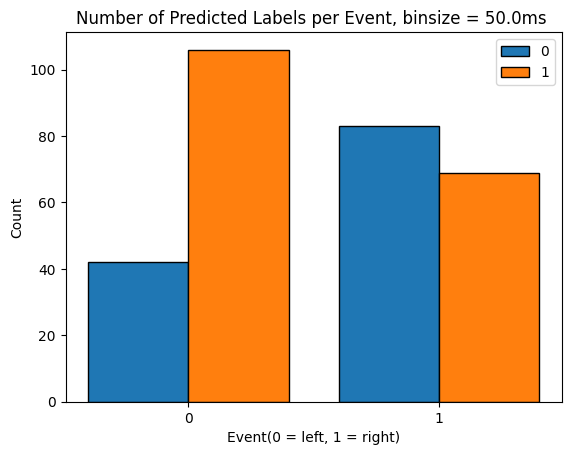

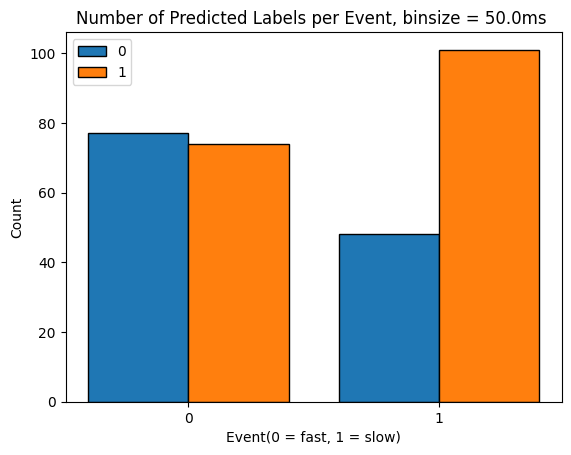

c:\Users\winni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Labels Unique:  [0 1] 

Labels Count:  [174 126]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Values for Left vs. Right 

Unique within event: 
 [array([0, 1]), array([0, 1])] 

Count within event: 
 [array([107,  41], dtype=int64), array([67, 85], dtype=int64)] 

Label for each event: 
 [0, 1]
Max count: 
 [107, 85] 

Accuracy: 
 0.64 

Accuracy: 
 (107 + 85 ) / 300 = 0.64 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fast vs. Slow
Label for each event: 
 [1, 0]
Max count: 
 [78, 101] 

Accuracy: 
 (78 + 101 ) / 300 = 0.5966666666666667 



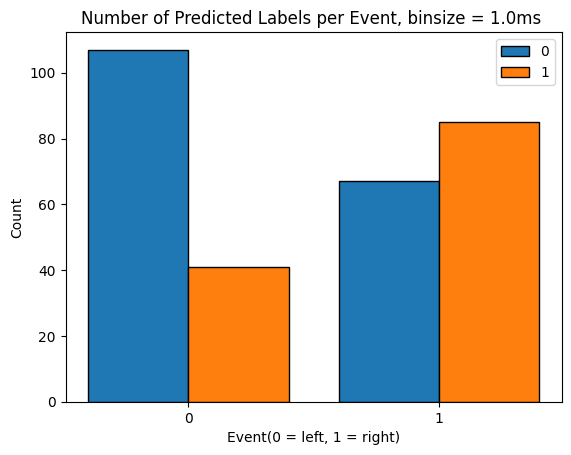

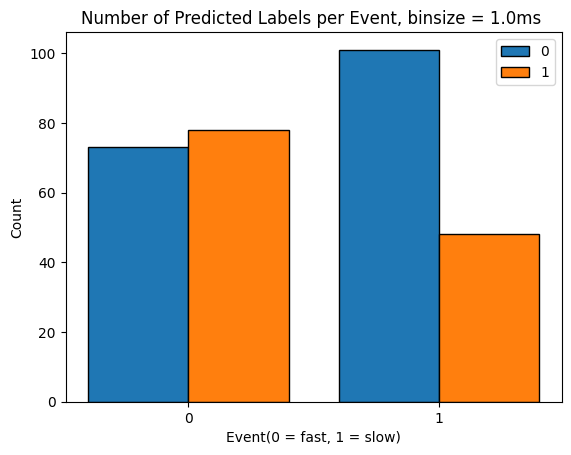

In [64]:
bin_size = 0.001
dist, ed, acc = get_info(bin_size, data, rand)
accuracy.append(acc)
distribution.append(dist)
event_dist.append(ed)

c:\Users\winni\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Labels Unique:  [0 1] 

Labels Count:  [117 183]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Values for Left vs. Right 

Unique within event: 
 [array([0, 1]), array([0, 1])] 

Count within event: 
 [array([ 37, 111], dtype=int64), array([80, 72], dtype=int64)] 

Label for each event: 
 [1, 0]
Max count: 
 [111, 80] 

Accuracy: 
 0.6366666666666667 

Accuracy: 
 (111 + 80 ) / 300 = 0.6366666666666667 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Fast vs. Slow
Label for each event: 
 [0, 1]
Max count: 
 [77, 109] 

Accuracy: 
 (77 + 109 ) / 300 = 0.6200000000000001 



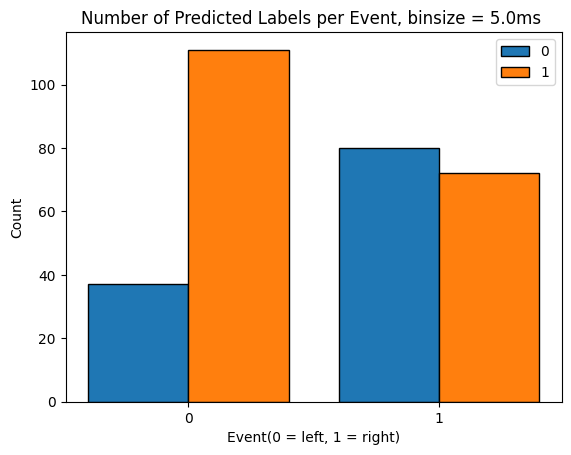

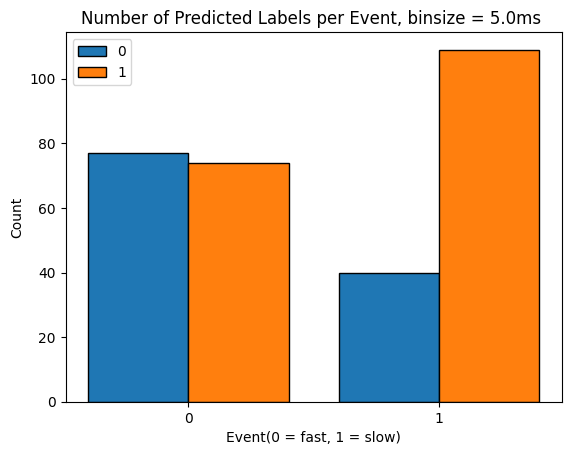

In [65]:
bin_size = 0.005
dist, ed, acc = get_info(bin_size, data, rand)
accuracy.append(acc)
distribution.append(dist)
event_dist.append(ed)

In [ ]:
bin_size = 0.05
dist, ed, acc = get_info(bin_size, data, rand)
accuracy.append(acc)
distribution.append(dist)
event_dist.append(ed)

In [66]:
#bin_size = 0.2
#dist, ed, acc = get_info(bin_size, data, rand)
#accuracy.append(acc)
#distribution.append(dist)
#event_dist.append(ed)
#rand
#distribution = [[int(num) for num in sublist] for sublist in distribution]
#distribution

#event_dist = [[[int(num) for num in inner_list] for inner_list in sublist] for sublist in event_dist]
#event_dist = [[[[int(num) for num in sublist] for sublist in list] for list in li ] for li in event_dist]
#event_dist

In [67]:
print('Distribution: \n', distribution, '\n')
print('Distribution within Events: \n', event_dist, '\n')

#accuracy is inaccurate if indexes are shared 
print('Accuracy: \n', accuracy, '\n')

Distribution: 
 [array([125, 175], dtype=int64), array([174, 126], dtype=int64), array([117, 183], dtype=int64)] 

Distribution within Events: 
 [[[array([ 42, 106], dtype=int64), array([83, 69], dtype=int64)], [array([77, 74], dtype=int64), array([ 48, 101], dtype=int64)]], [[array([107,  41], dtype=int64), array([67, 85], dtype=int64)], [array([73, 78], dtype=int64), array([101,  48], dtype=int64)]], [[array([ 37, 111], dtype=int64), array([80, 72], dtype=int64)], [array([77, 74], dtype=int64), array([ 40, 109], dtype=int64)]]] 

Accuracy: 
 [[0.63, 0.5933333333333334], [0.64, 0.5966666666666667], [0.6366666666666667, 0.6200000000000001]] 

